<a href="https://colab.research.google.com/github/chinweeee/Forecasting_US_Outbound_Travel_Passengers/blob/main/%5BMRP'24%5D_Forecasting_US_Outbound_Travel_Passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt




import matplotlib.pyplot as plt
color_pallete = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
#pd.set_option('display.float_format', '{:.6f}'.format)
#pd.options.display.float_format = '{:,.2f}'.format


In [ ]:
data = pd.read_csv('new_combined.csv')
data.head()

Date           Regions  Passengers  new_Passengers
0  2013-01-01            Europe    563169.0        563169.0
1  2013-01-01         Caribbean    468194.0        468194.0
2  2013-01-01              Asia    372244.0        372244.0
3  2013-01-01     South America    125428.0        125428.0
4  2013-01-01  Central America     200178.0        200178.0

In [ ]:
data.Date = pd.to_datetime(data.Date)

In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' to datetime objects
data = data.set_index('Date')  # Set 'Date' as the index

dayofweek_values = data.index.dayofweek
print(dayofweek_values)

Index([1, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       ...
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype='int32', name='Date', length=1056)


In [ ]:
data.head()

Regions  Passengers  new_Passengers
Date                                                    
2013-01-01            Europe    563169.0        563169.0
2013-01-01         Caribbean    468194.0        468194.0
2013-01-01              Asia    372244.0        372244.0
2013-01-01     South America    125428.0        125428.0
2013-01-01  Central America     200178.0        200178.0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1056 entries, 2013-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Regions         1056 non-null   object 
 1   Passengers      1048 non-null   float64
 2   new_Passengers  1056 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.0+ KB


### Pre-Covid Analysis 2013-2019

In [ ]:
pre_covid = data.loc['2013-01-01':'2019-12-31']
pre_covid.tail()

Regions  Passengers  new_Passengers
Date                                                    
2019-12-01     South America    279714.0        279714.0
2019-12-01  Central America     373412.0        373412.0
2019-12-01           Oceania    108902.0        108902.0
2019-12-01       Middle East    252460.0        252460.0
2019-12-01            Africa     58656.0         58656.0

In [ ]:
pre_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2013-01-01 to 2019-12-01
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Regions         672 non-null    object 
 1   Passengers      672 non-null    float64
 2   new_Passengers  672 non-null    float64
dtypes: float64(2), object(1)
memory usage: 21.0+ KB


In [ ]:
pre_covid.dtypes

Regions            object
Passengers        float64
new_Passengers    float64
dtype: object

In [ ]:
pre_covid.isnull().sum()

Regions           0
Passengers        0
new_Passengers    0
dtype: int64

##### Descriptive Statistics

In [ ]:
pre_covid['Passengers'].describe()

count    6.720000e+02
mean     3.759398e+05
std      4.163842e+05
min      2.034300e+04
25%      1.088165e+05
50%      2.086120e+05
75%      5.142005e+05
max      2.574573e+06
Name: Passengers, dtype: float64

#### Pre-Covid Univariate Analysis

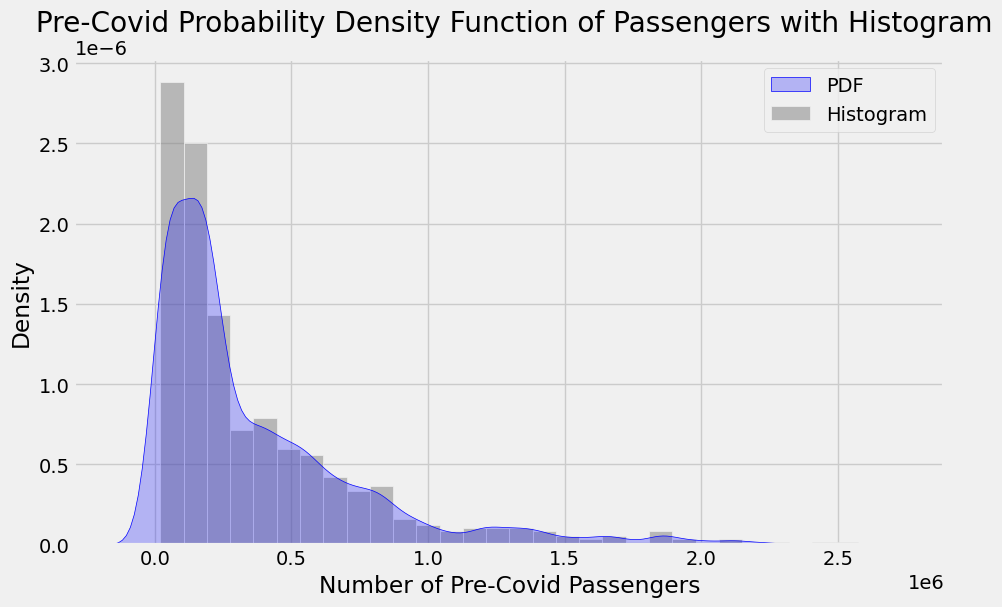

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(pre_covid['Passengers'], bins=30, kde=False, stat='density', color='gray', alpha=0.5, label='Histogram')

sns.kdeplot(pre_covid['Passengers'], bw_adjust=0.5, color='blue', label='PDF', fill=True)

plt.title(' Pre-Covid Probability Density Function of Passengers with Histogram')
plt.xlabel('Number of Pre-Covid Passengers')
plt.ylabel('Density')
plt.legend()

plt.show()

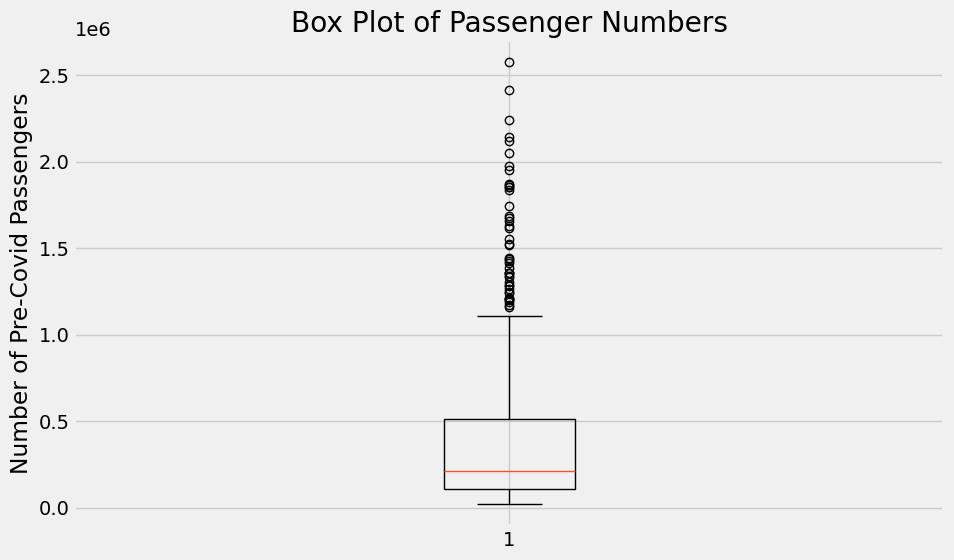

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(pre_covid['Passengers'])

plt.title('Box Plot of Passenger Numbers')
plt.ylabel('Number of Pre-Covid Passengers')
plt.grid(True)

plt.show()

In [ ]:
#pre_covid[['Date', 'Regions', 'Passengers']].info()

pre_covid[['Regions', 'Passengers']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2013-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Regions     672 non-null    object 
 1   Passengers  672 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
pre_covid.head()

Regions  Passengers  new_Passengers
Date                                                    
2013-01-01            Europe    563169.0        563169.0
2013-01-01         Caribbean    468194.0        468194.0
2013-01-01              Asia    372244.0        372244.0
2013-01-01     South America    125428.0        125428.0
2013-01-01  Central America     200178.0        200178.0

In [ ]:
pre_covid.describe()

Passengers  new_Passengers
count  6.720000e+02    6.720000e+02
mean   3.759398e+05    3.759398e+05
std    4.163842e+05    4.163842e+05
min    2.034300e+04    2.034300e+04
25%    1.088165e+05    1.088165e+05
50%    2.086120e+05    2.086120e+05
75%    5.142005e+05    5.142005e+05
max    2.574573e+06    2.574573e+06

In [ ]:
new_pre = pre_covid[['Regions', 'Passengers']]
new_pre.head()

Regions  Passengers
Date                                    
2013-01-01            Europe    563169.0
2013-01-01         Caribbean    468194.0
2013-01-01              Asia    372244.0
2013-01-01     South America    125428.0
2013-01-01  Central America     200178.0

In [ ]:
pre_covid.tail()

Regions  Passengers  new_Passengers
Date                                                    
2019-12-01     South America    279714.0        279714.0
2019-12-01  Central America     373412.0        373412.0
2019-12-01           Oceania    108902.0        108902.0
2019-12-01       Middle East    252460.0        252460.0
2019-12-01            Africa     58656.0         58656.0

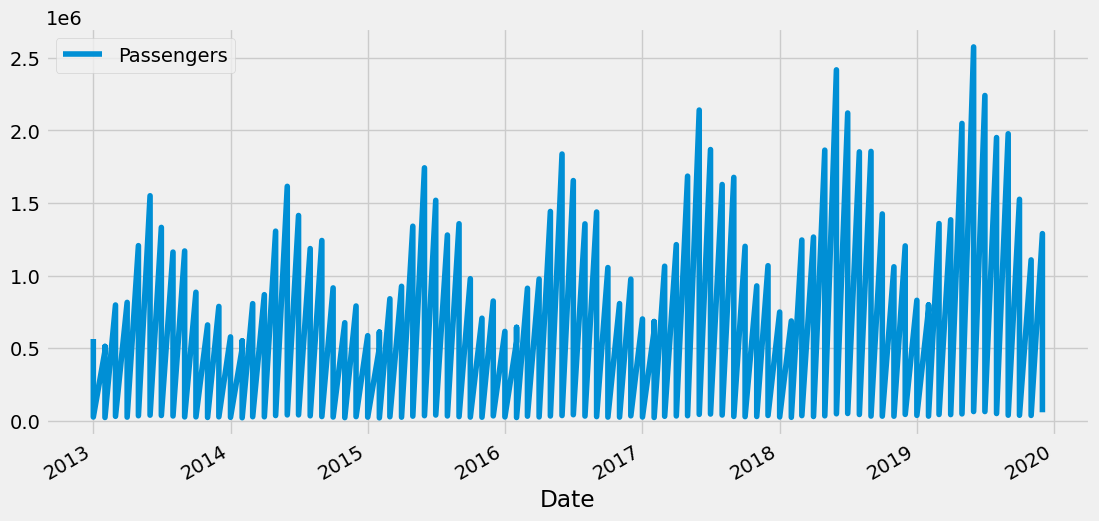

In [ ]:
pre_covid.plot(y='Passengers', kind='line', figsize=(12, 6))
plt.show()

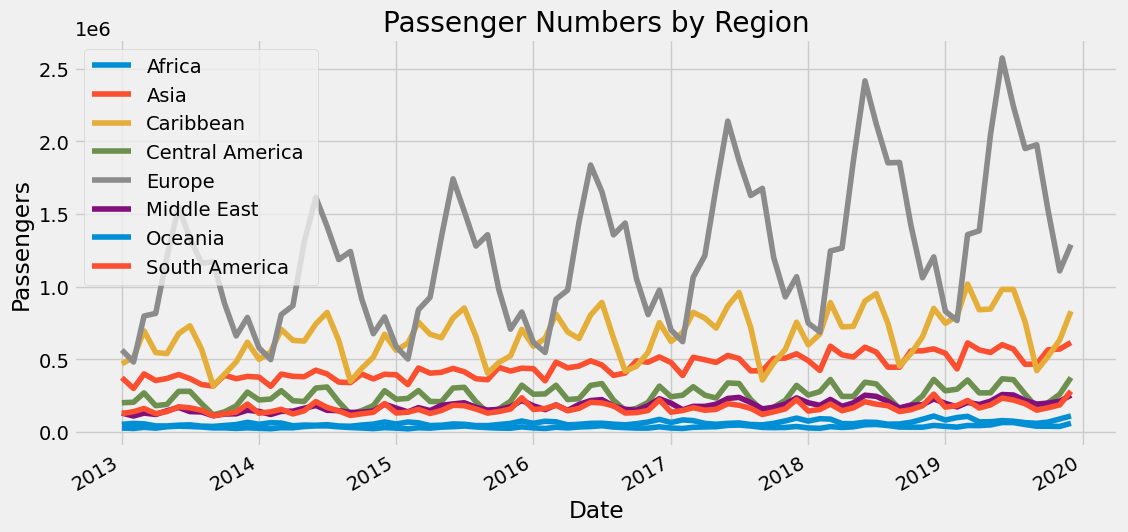

In [ ]:
pre_covid_reset = pre_covid.reset_index()

plt.figure(figsize=(12, 6))

# Group the data by 'Regions' (using pre_covid_reset)
for region, group in pre_covid_reset.groupby('Regions'):
    plt.plot(group['Date'], group['Passengers'], label=region)


plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Passenger Numbers by Region')
plt.legend()
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.show()


In [ ]:
pre_covid_reset.describe()

Date    Passengers  new_Passengers
count                            672  6.720000e+02    6.720000e+02
mean   2016-06-16 01:08:34.285714176  3.759398e+05    3.759398e+05
min              2013-01-01 00:00:00  2.034300e+04    2.034300e+04
25%              2014-09-23 12:00:00  1.088165e+05    1.088165e+05
50%              2016-06-16 00:00:00  2.086120e+05    2.086120e+05
75%              2018-03-08 18:00:00  5.142005e+05    5.142005e+05
max              2019-12-01 00:00:00  2.574573e+06    2.574573e+06
std                              NaN  4.163842e+05    4.163842e+05

In [ ]:

pre_covid_reset = pre_covid.reset_index()
new_pre = pre_covid_reset[['Date', 'Regions', 'Passengers']]
new_pre.head()

Date           Regions  Passengers
0 2013-01-01            Europe    563169.0
1 2013-01-01         Caribbean    468194.0
2 2013-01-01              Asia    372244.0
3 2013-01-01     South America    125428.0
4 2013-01-01  Central America     200178.0

### Train/Test Split

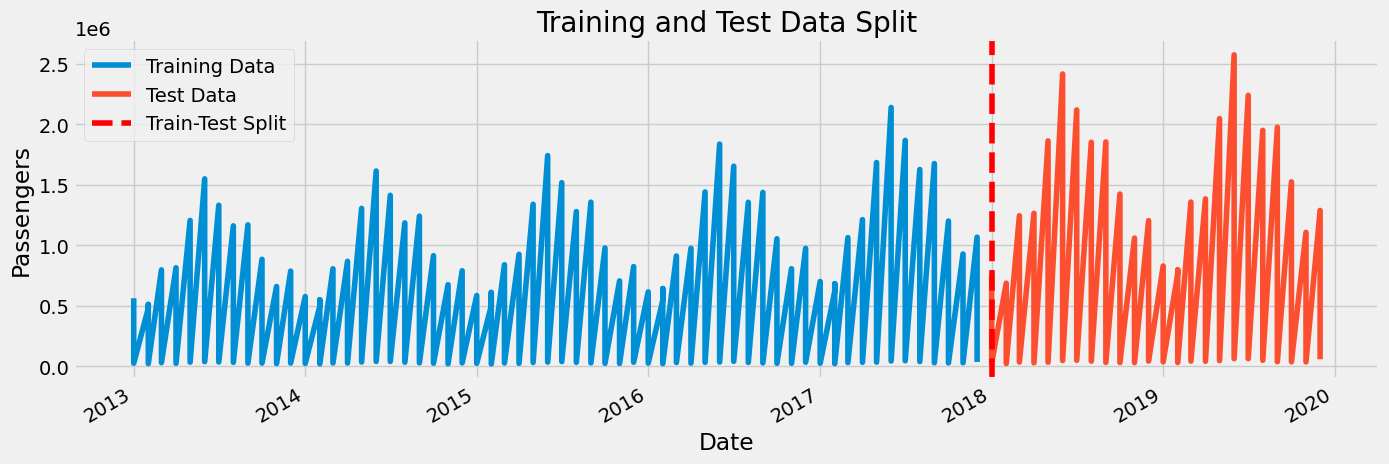

In [ ]:

train_data = new_pre[new_pre['Date'] < '2018-01-01']
test_data = new_pre[new_pre['Date'] >= '2018-01-01']

fig, ax = plt.subplots(figsize=(15, 5))

train_data.plot(x='Date', y='Passengers', ax=ax, label='Training Data')
test_data.plot(x='Date', y='Passengers', ax=ax, label='Test Data')

ax.axvline('2018-01-01', color='red', linestyle='--', label='Train-Test Split')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Training and Test Data Split')
plt.legend()
plt.grid(True)
plt.show()

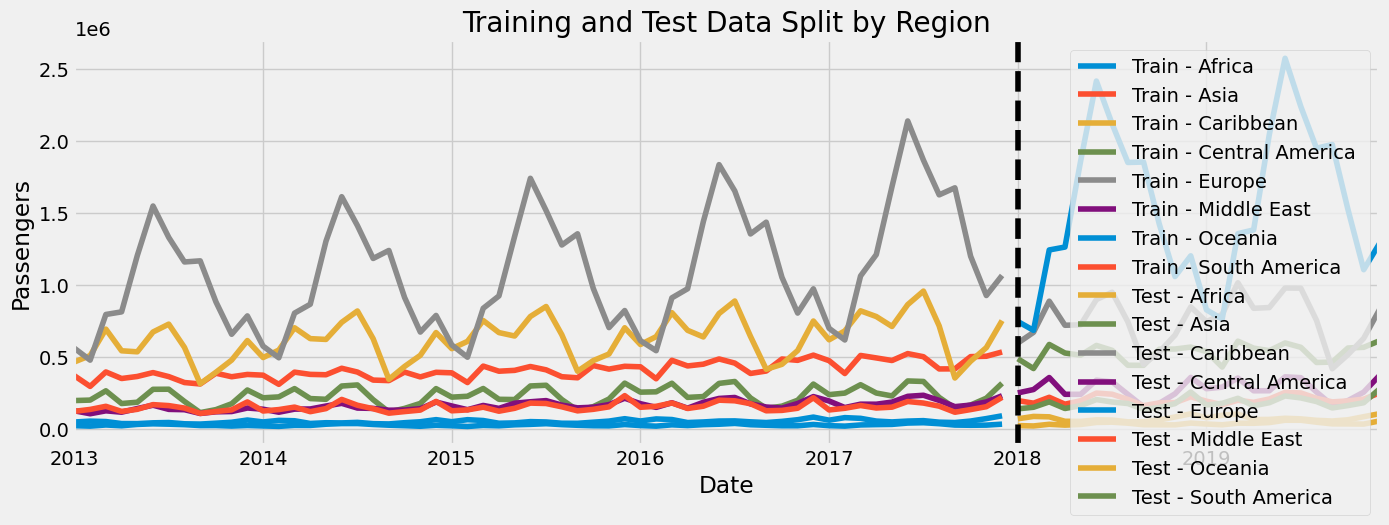

In [ ]:
train_data = new_pre[new_pre['Date'] < '2018-01-01']
test_data = new_pre[new_pre['Date'] >= '2018-01-01']

fig, ax = plt.subplots(figsize=(15, 5))

for region, group in train_data.groupby('Regions'):
    group.plot(x='Date', y='Passengers', ax=ax, label=f'Train - {region}')

for region, group in test_data.groupby('Regions'):
    group.plot(x='Date', y='Passengers', ax=ax, label=f'Test - {region}')

ax.axvline('2018-01-01', color='black', ls='--')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Training and Test Data Split by Region')
plt.legend()
plt.grid(True)
plt.show()

### Feature Creation

In [ ]:
def create_features(new_pre):
    """
    Create time series features based on time series index.
    """
    new_pre_copy = new_pre.copy()
    new_pre_copy['dayofweek'] = new_pre_copy.Date.dt.dayofweek  # Use dt accessor
    new_pre_copy['quarter'] = new_pre_copy.Date.dt.quarter
    new_pre_copy['month'] = new_pre_copy.Date.dt.month
    new_pre_copy['year'] = new_pre_copy.Date.dt.year
    new_pre_copy['dayofyear'] = new_pre_copy.Date.dt.dayofyear  # Complete the line
    return new_pre_copy


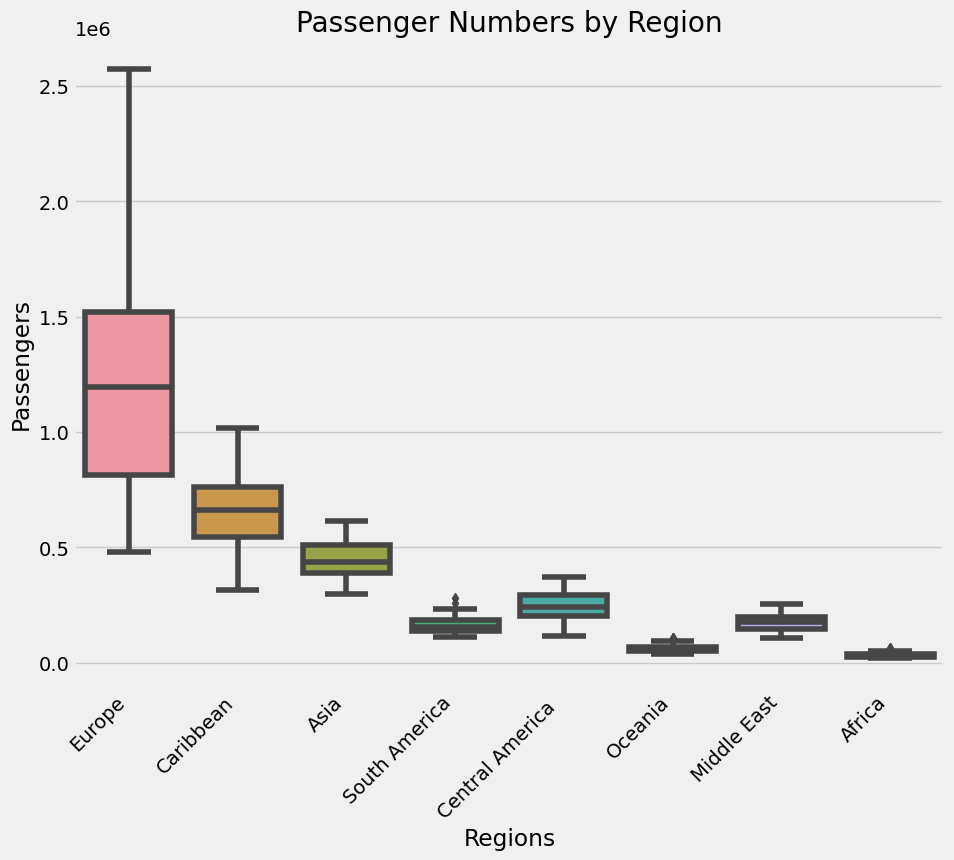

In [ ]:
new_pre_copy = create_features(new_pre)
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=new_pre_copy, x='Regions', y='Passengers')
ax.set_title('Passenger Numbers by Region')
plt.xticks(rotation=45, ha='right')
plt.show()

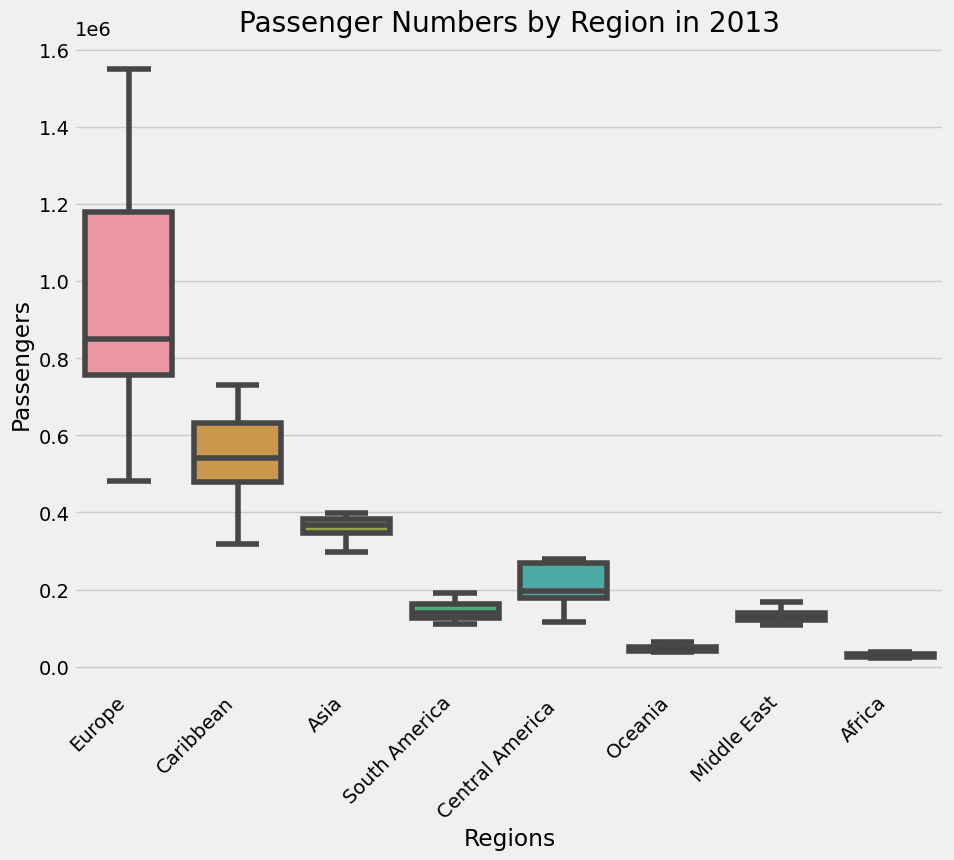

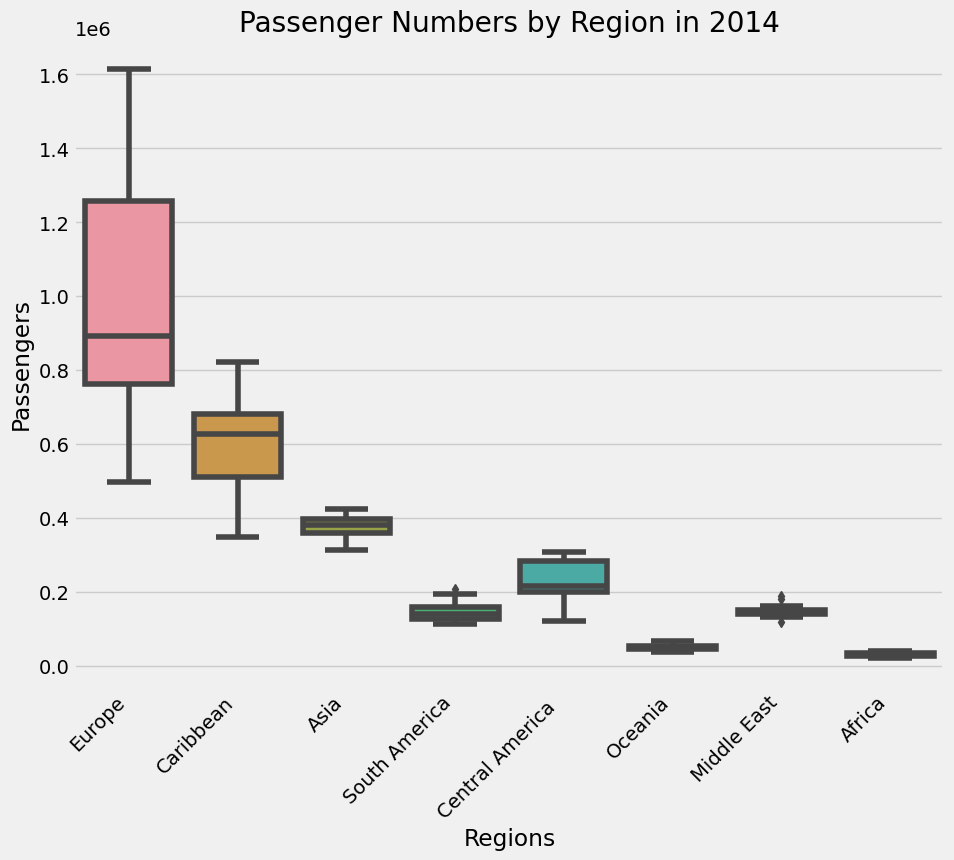

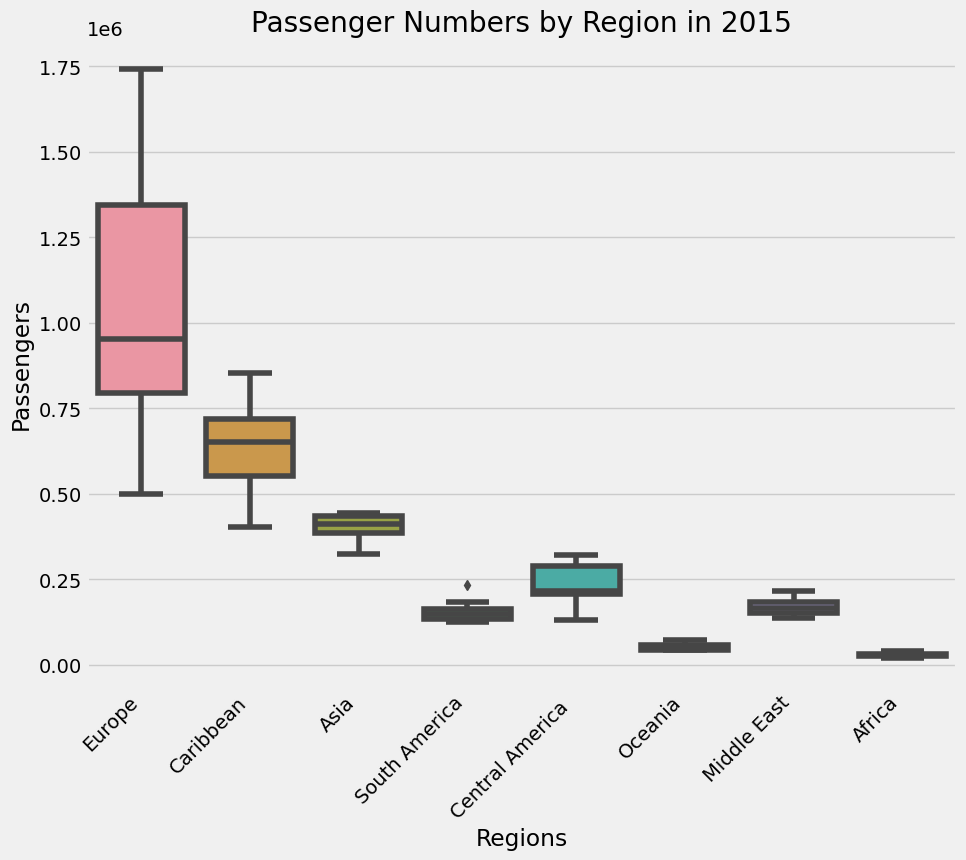

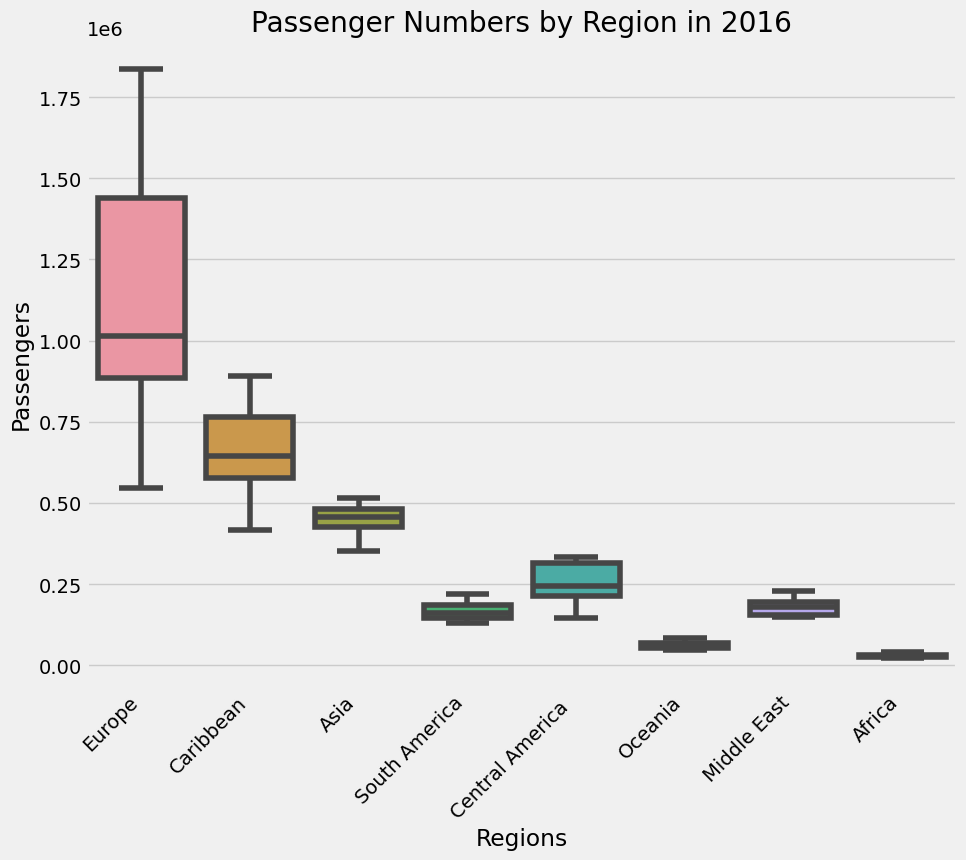

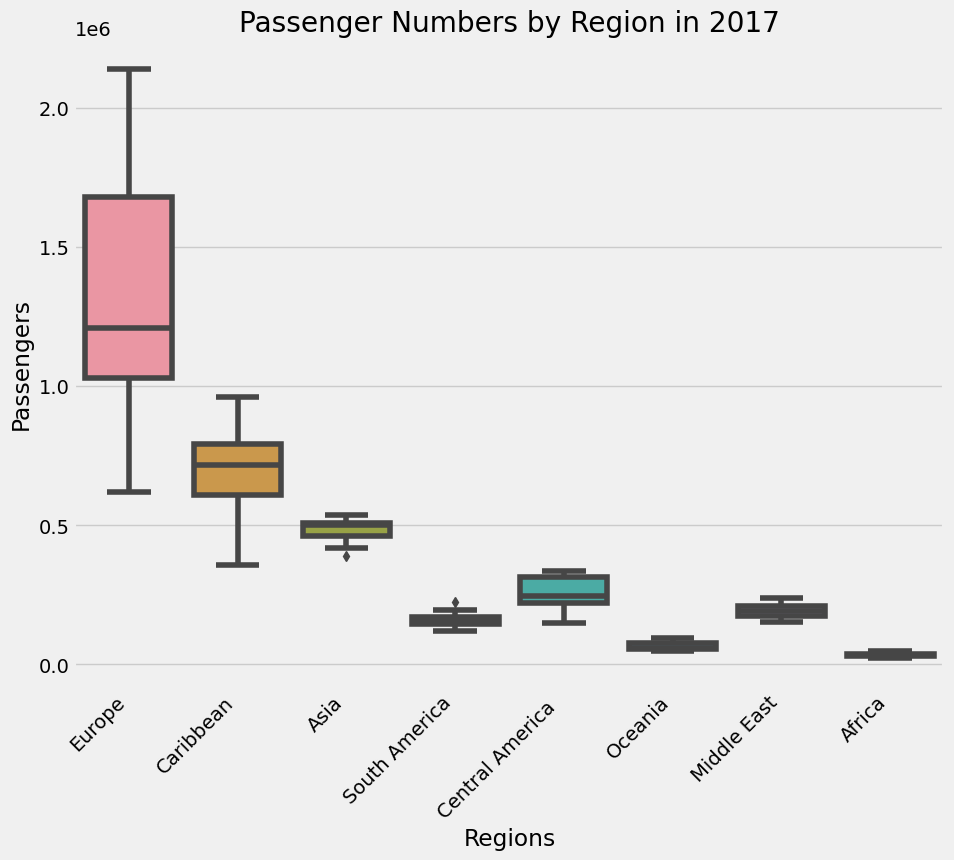

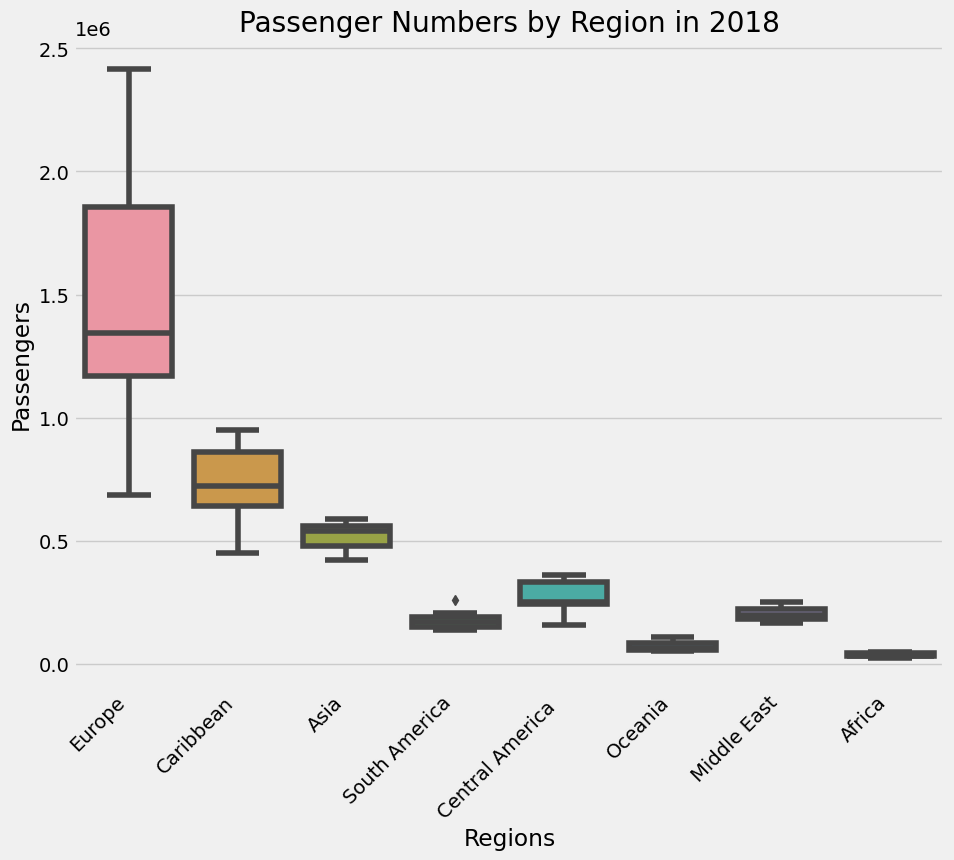

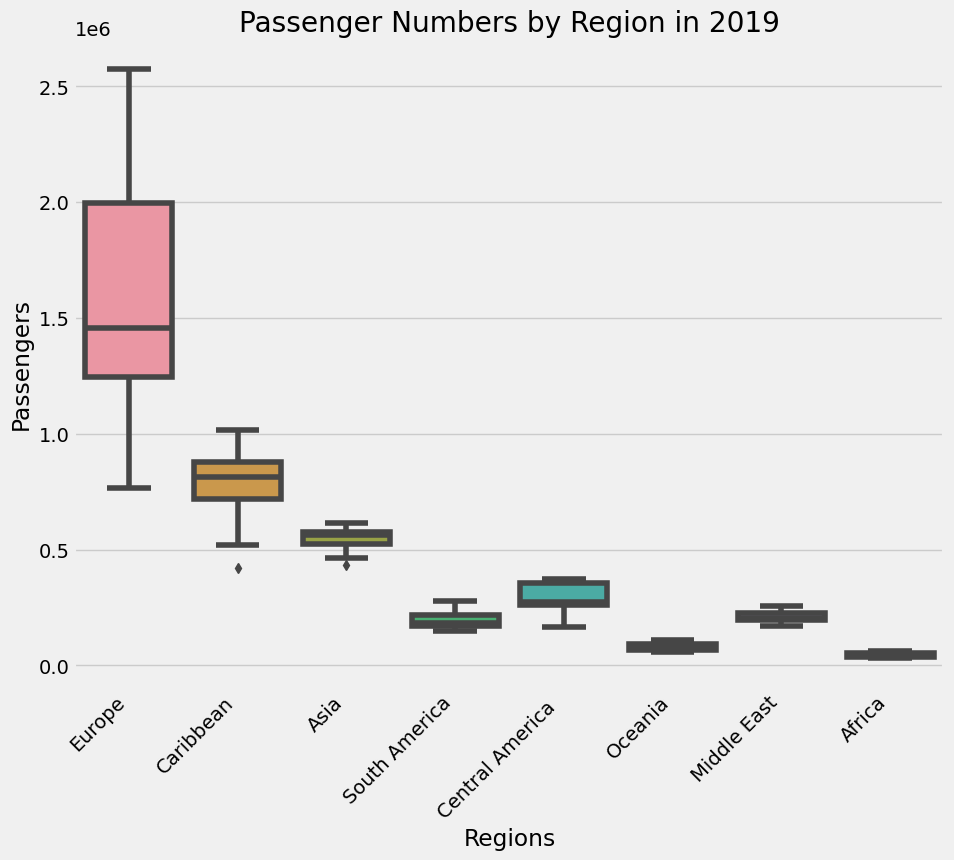

In [ ]:
for year in new_pre_copy['year'].unique():
    year_data = new_pre_copy[new_pre_copy['year'] == year]
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(data=year_data, x='Regions', y='Passengers')
    ax.set_title(f'Passenger Numbers by Region in {year}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

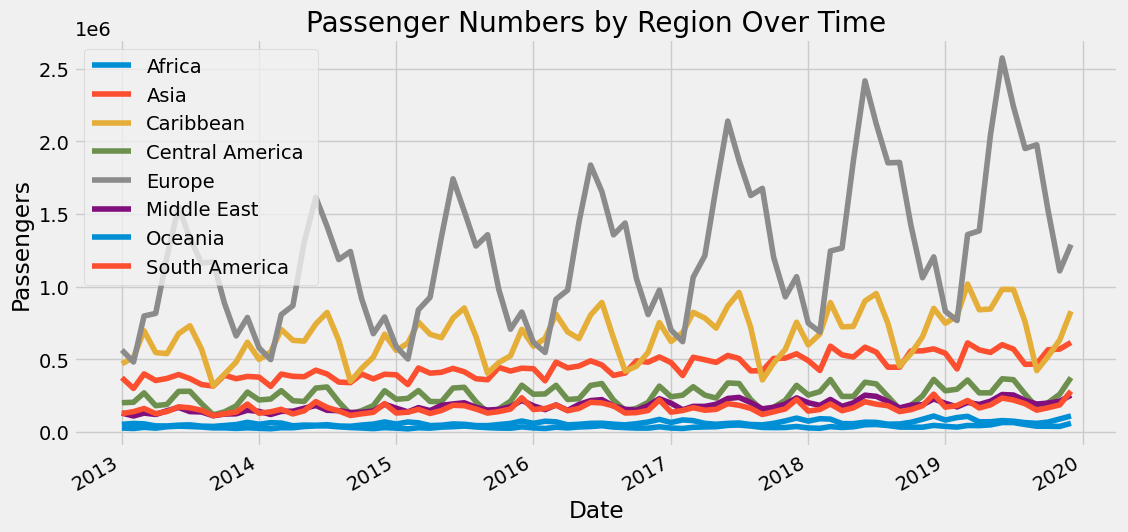

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
for region, group in new_pre_copy.groupby('Regions'):
    plt.plot(group['Date'], group['Passengers'], label=region)

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Passenger Numbers by Region Over Time')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# Time-series Forecasting Model
- ARIMA
- SARIMA

In [ ]:
test_data['Passengers'].shape

(192,)

### Using the ARIMA Model

In [ ]:
history = train_data['Passengers'].tolist()
predictions = list()
# walk-forward validation
for t in range(len(test_data)):
#for t in range(5):
  model = ARIMA(history, order=(5,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_data.iloc[t]['Passengers']
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts

rmse = sqrt(mean_squared_error(test_data['Passengers'], predictions))
mae = mean_squared_error(test_data['Passengers'], predictions)
r2 = r2_score(test_data['Passengers'], predictions)



predicted=271156.445251, expected=748793.000000
predicted=430952.569721, expected=598896.000000
predicted=545467.171831, expected=490348.000000
predicted=269801.831695, expected=142741.000000
predicted=329039.935495, expected=253091.000000
predicted=159333.664891, expected=73516.000000
predicted=354407.442676, expected=200003.000000
predicted=271699.014829, expected=26621.000000
predicted=242944.469445, expected=687296.000000
predicted=377034.534427, expected=673271.000000
predicted=550248.424978, expected=422237.000000
predicted=241626.586489, expected=153627.000000
predicted=296200.969740, expected=276689.000000
predicted=199641.740806, expected=90014.000000
predicted=316864.897542, expected=181962.000000
predicted=300251.246179, expected=23962.000000
predicted=218229.921632, expected=1244957.000000
predicted=672967.491833, expected=889631.000000
predicted=726336.063802, expected=589421.000000
predicted=310819.813628, expected=191110.000000
predicted=440182.956322, expected=359897.00

Test RMSE: 546630.267
Test MAE: 298804648761.337
Test R2: -0.161


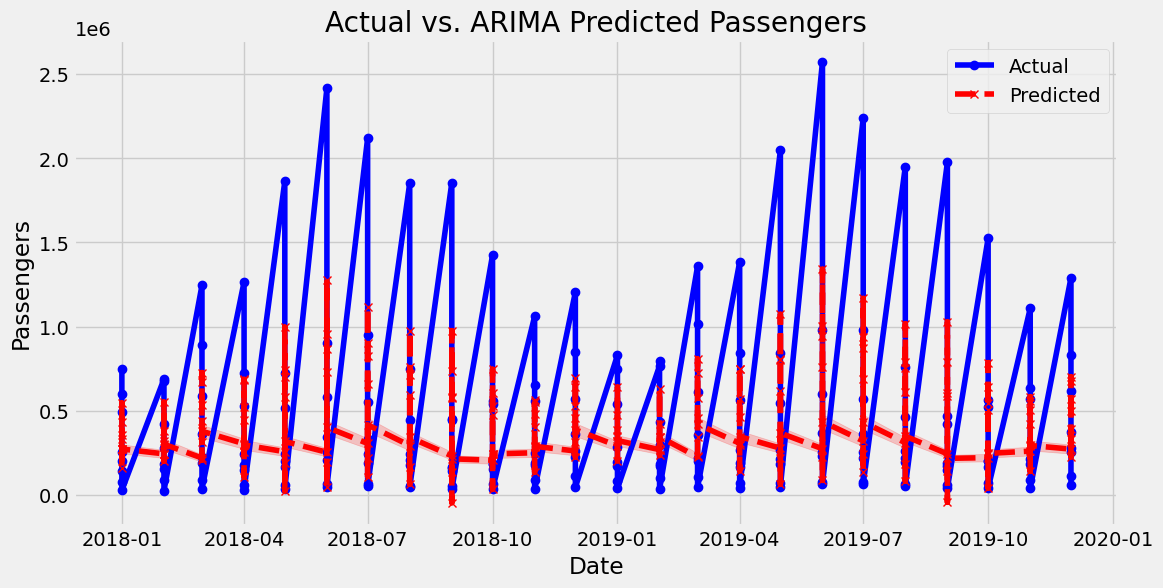

In [ ]:
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Passengers'], label='Actual', linestyle='-', marker='o', color='blue')
plt.plot(test_data['Date'], predictions, label='Predicted', linestyle='--', marker='x', color='red')
plt.fill_between(test_data['Date'], 0.9 * pd.Series(predictions), 1.1 * pd.Series(predictions), color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Actual vs. ARIMA Predicted Passengers')
plt.legend()
plt.grid(True)

plt.show()

#### With Regions

/var/folders/29/z_qcrfh91n30mjn_998lcrcm0000gp/T/ipykernel_74623/866772190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = predictions


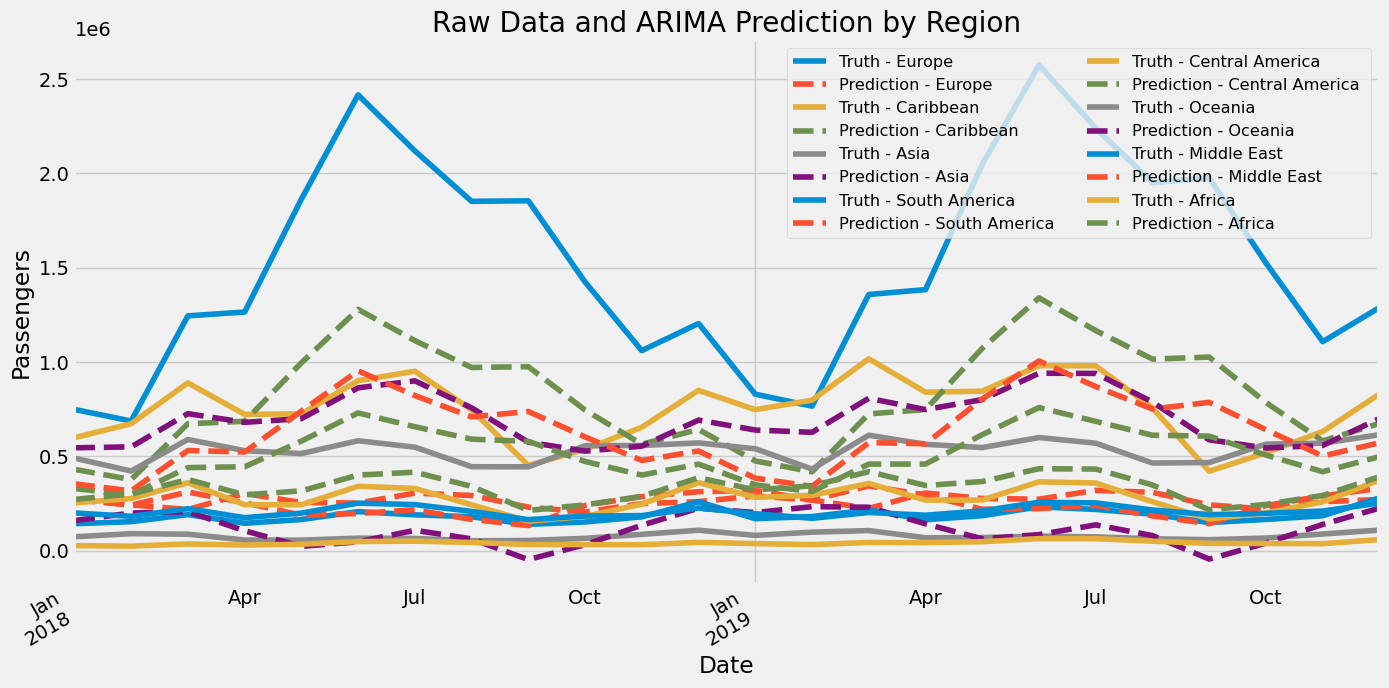

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

test_data['prediction'] = predictions

for region in test_data['Regions'].unique():
    region_data = test_data[test_data['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust location, font size, and number of columns

ax.set_title('Raw Data and ARIMA Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# Machine Learning Algorithms
- XGBoost
- Random Forest

### Create the Model

In [ ]:
train = create_features(train_data)
test = create_features(test_data)


train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])


FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]

TARGET = 'Passengers'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


### Using the XGBoost

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211
[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532


/Users/chinwe/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:23:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Feature Importance

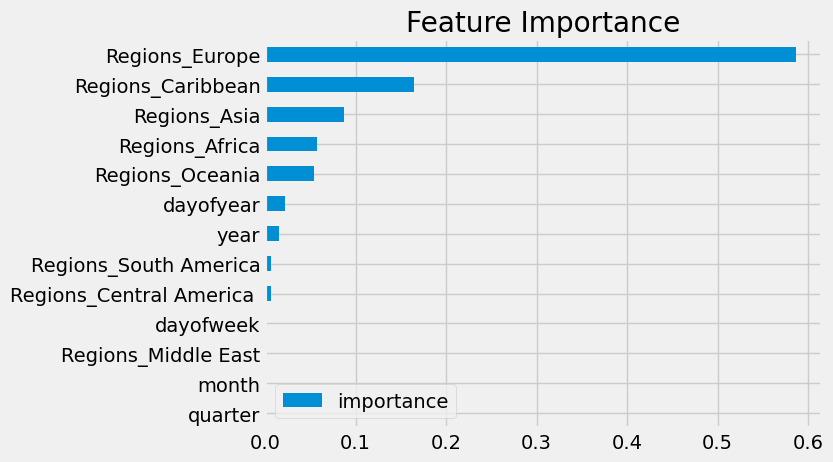

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Results

## Forecast on Test Data

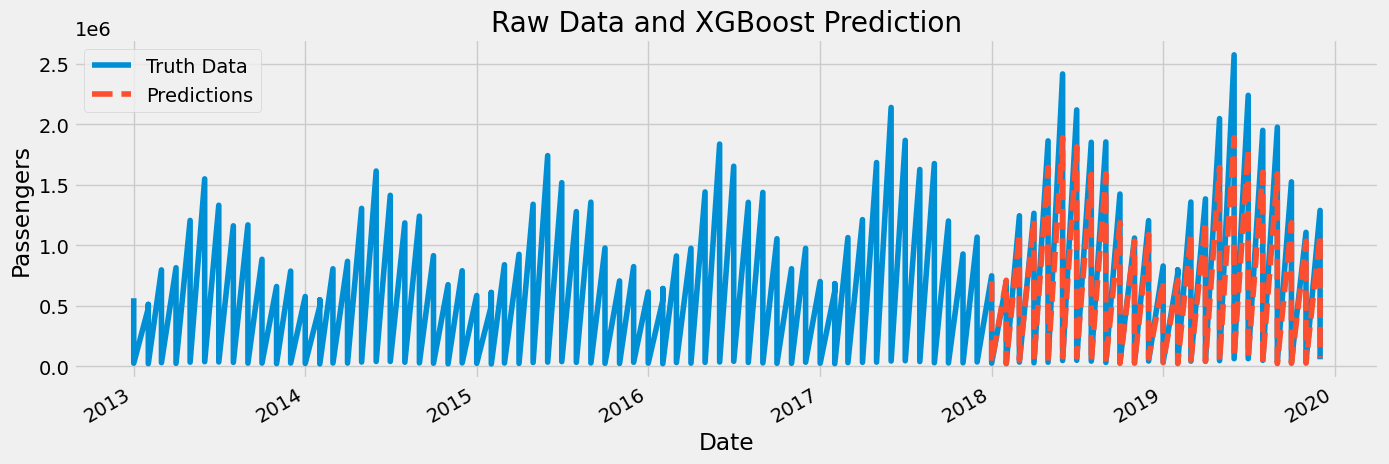

In [ ]:
test['prediction'] = reg.predict(X_test)

new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = new_pre_copy_new.plot(x='Date', y='Passengers', figsize=(15, 5), label='Truth Data')
new_pre_copy_new.plot(x='Date', y='prediction', ax=ax, style='--', label='Predictions')

plt.legend()
ax.set_title('Raw Data and XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

### With Regions

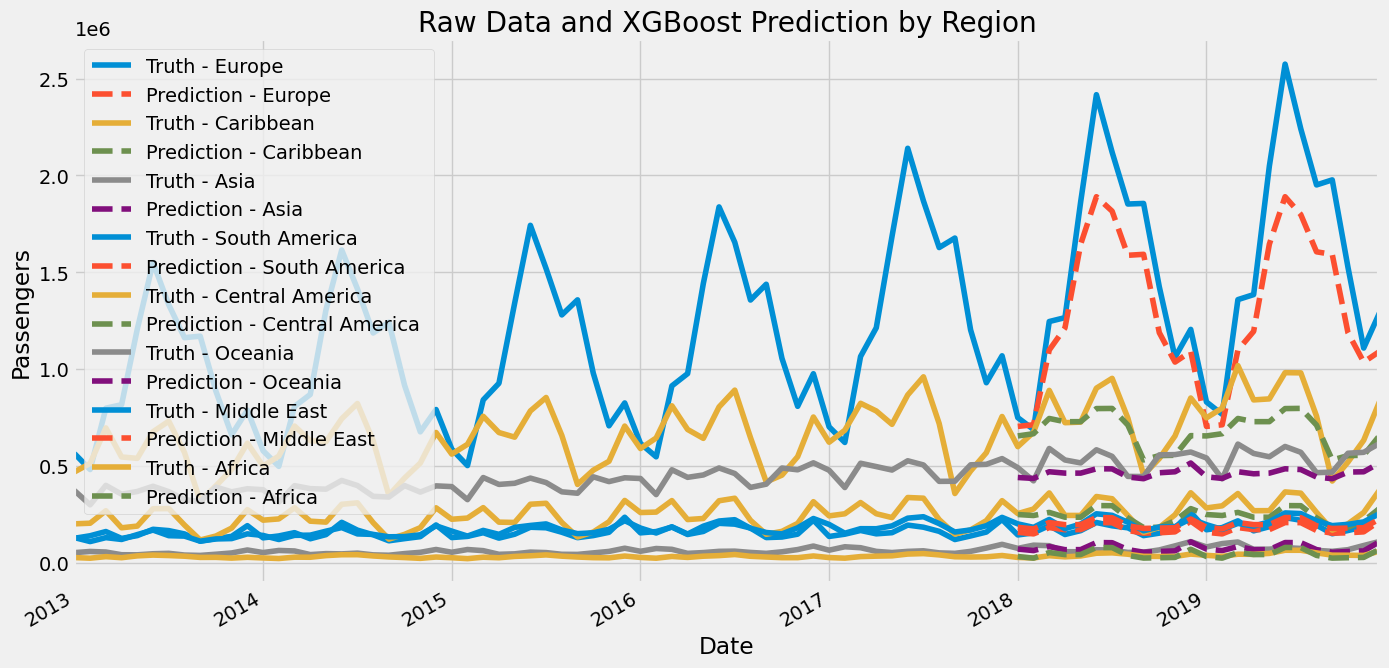

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend()
ax.set_title('Raw Data and XGBoost Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

### Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['Passengers'], test['prediction']))
print(f'XGBoost RMSE Score on Test set: {score:0.2f}')
print(f'XGBoost R2 Score on Test set: {r2_score(test["Passengers"], test["prediction"]):0.2f}')
print(f'XGBoost MAE Score on Test set: {mean_absolute_error(test["Passengers"], test["prediction"]):0.2f}')

XGBoost RMSE Score on Test set: 117383.98
XGBoost R2 Score on Test set: 0.95
XGBoost MAE Score on Test set: 63896.26


### Error Calculation

- Now I want to look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby(['Date'])['error'].mean().sort_values(ascending=False)

Date
2019-06-01    143320.885742
2018-06-01    108016.135742
2019-07-01    107206.260742
2019-03-01    105643.026855
2019-05-01     84605.779297
2019-12-01     84284.123047
2018-07-01     81749.432617
2019-09-01     72313.105225
2018-03-01     70057.929199
2019-10-01     67416.821777
2018-12-01     64941.791016
2019-08-01     64050.930664
2019-04-01     57218.329590
2018-09-01     51333.858887
2019-01-01     49378.183838
2019-11-01     48501.465088
2018-08-01     46119.133789
2018-10-01     46017.114746
2019-02-01     39825.577148
2018-05-01     38749.970703
2018-11-01     37795.965088
2018-04-01     25349.912598
2018-01-01     24542.213623
2018-02-01     15072.327148
Name: error, dtype: float64

## Random Forest Model

Random Forest RMSE: 117761.59735485638
Random Forest R2: 0.9461370305773715
Random Forest MAE: 63931.69359375


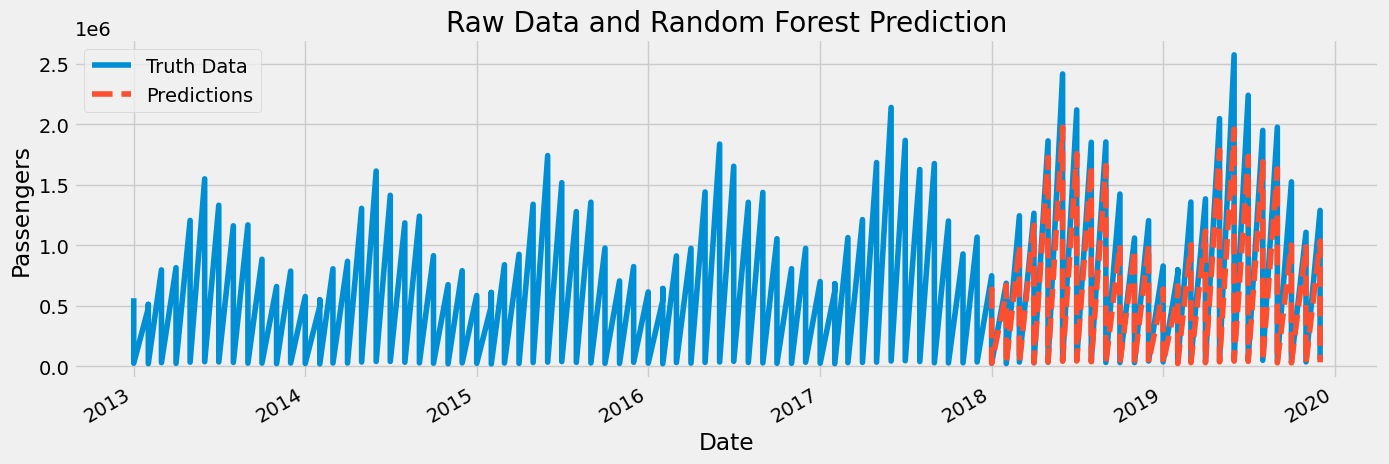

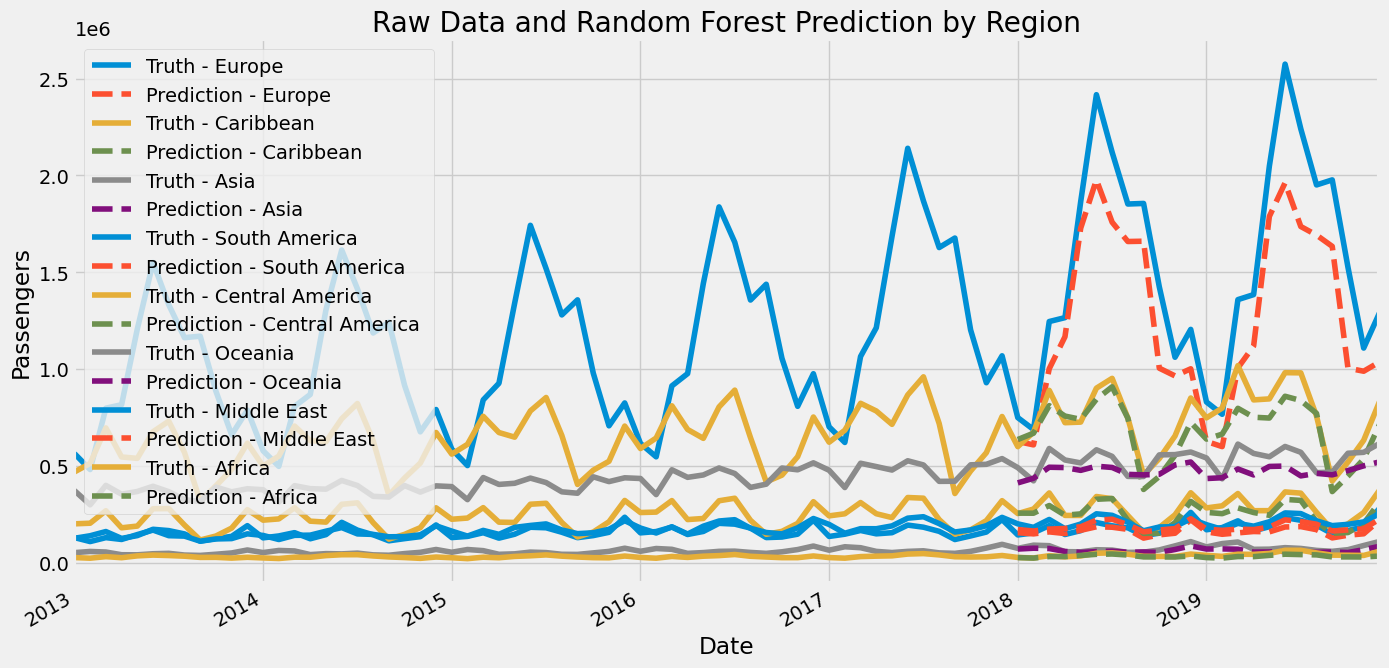

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse}")

#Calculate R2
r2 = r2_score(y_test, y_pred)
print(f"Random Forest R2: {r2}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest MAE: {mae}")

# Merge predictions with the original data
test['prediction'] = y_pred
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot overall data and predictions
ax = new_pre_copy_new.plot(x='Date', y='Passengers', figsize=(15, 5), label='Truth Data')
new_pre_copy_new.plot(x='Date', y='prediction', ax=ax, style='--', label='Predictions')

plt.legend()
ax.set_title('Raw Data and Random Forest Prediction')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

# Plot data and predictions by region
fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend()
ax.set_title('Raw Data and Random Forest Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

## Deep Learning Approaches
- LSTM
- GRU

## LSTM

Epoch 1/200


/Users/chinwe/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 1s - 68ms/step - loss: 0.0401 - val_loss: 0.0615
Epoch 2/200
15/15 - 0s - 2ms/step - loss: 0.0246 - val_loss: 0.0444
Epoch 3/200
15/15 - 0s - 2ms/step - loss: 0.0186 - val_loss: 0.0348
Epoch 4/200
15/15 - 0s - 2ms/step - loss: 0.0119 - val_loss: 0.0236
Epoch 5/200
15/15 - 0s - 2ms/step - loss: 0.0068 - val_loss: 0.0147
Epoch 6/200
15/15 - 0s - 2ms/step - loss: 0.0052 - val_loss: 0.0115
Epoch 7/200
15/15 - 0s - 2ms/step - loss: 0.0050 - val_loss: 0.0111
Epoch 8/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0112
Epoch 9/200
15/15 - 0s - 2ms/step - loss: 0.0048 - val_loss: 0.0112
Epoch 10/200
15/15 - 0s - 2ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 11/200
15/15 - 0s - 2ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 12/200
15/15 - 0s - 2ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 13/200
15/15 - 0s - 2ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 14/200
15/15 - 0s - 4ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 15/200
15/15 - 0s - 2ms/step - loss: 0.0046 - va

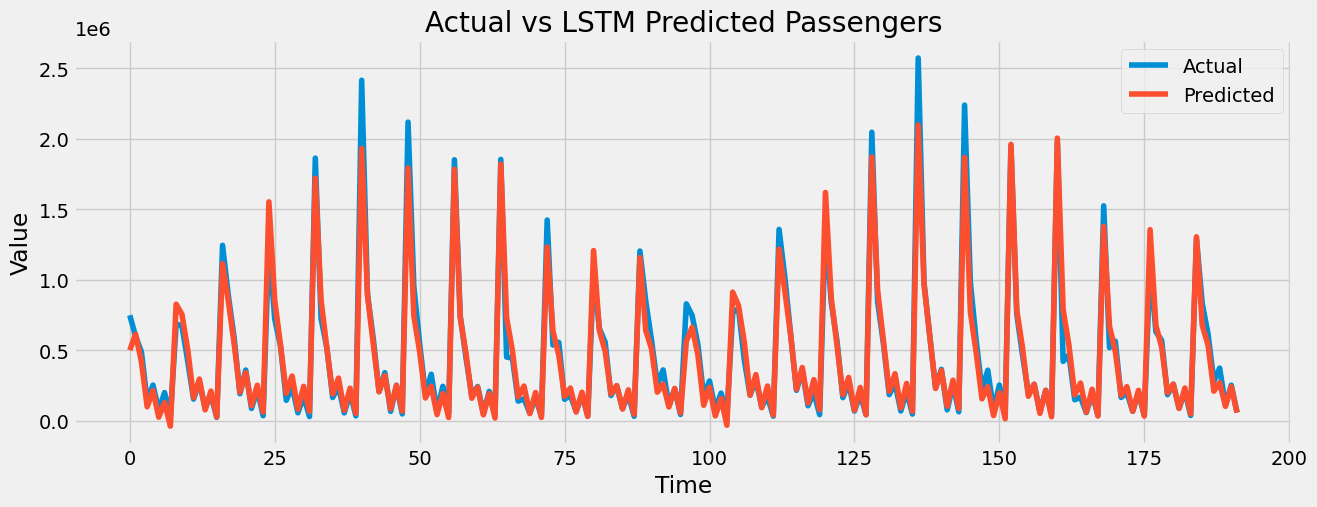

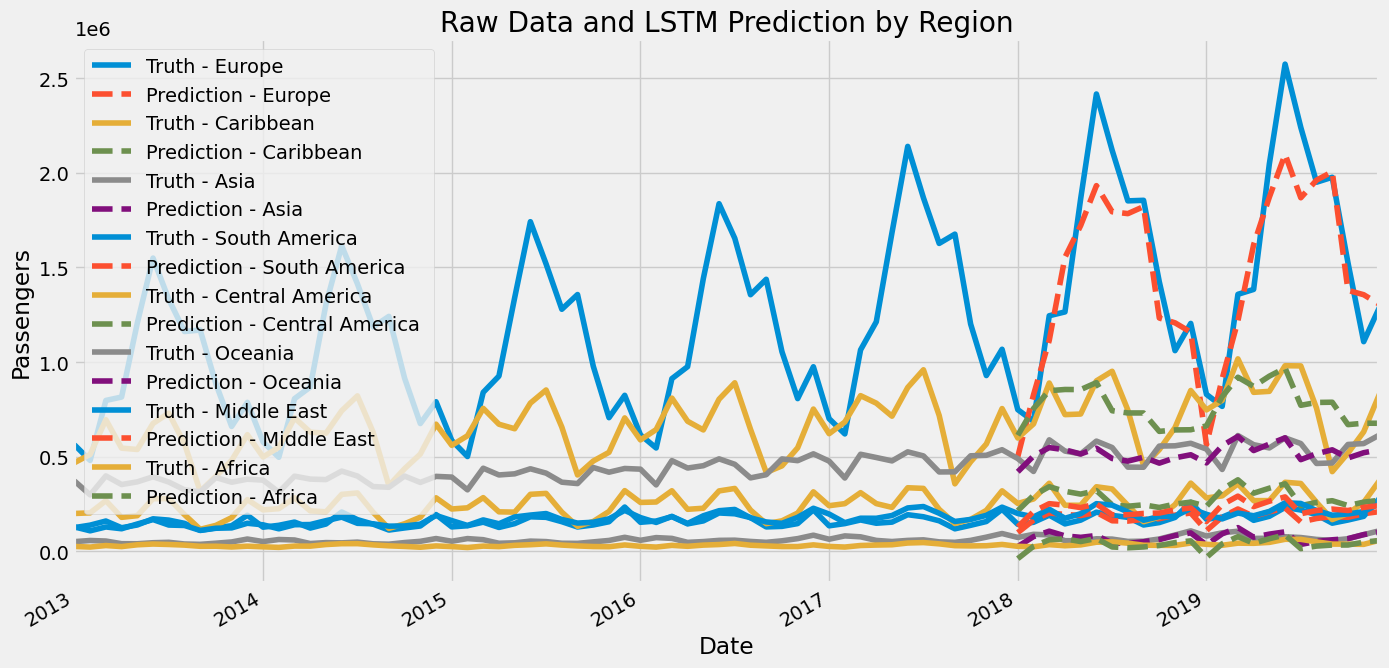

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

# 1. Preprocess Data: Scale features and target
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

# Reshape input to be 3D [samples, time steps, features] for LSTM
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 2. Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

# 3. Make Predictions
y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs LSTM Predicted Passengers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend()
ax.set_title('Raw Data and LSTM Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
lmean_actual = 375939.8
lrmse = 103053.31073488624

lrelative_rmse = (lrmse / lmean_actual) * 100
print(f'Relative RMSE: {lrelative_rmse:.2f}%')

Relative RMSE: 27.41%


## GRU Model Predictions

Epoch 1/200


/Users/chinwe/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 1s - 83ms/step - loss: 0.0298 - val_loss: 0.0426
Epoch 2/200
15/15 - 0s - 2ms/step - loss: 0.0154 - val_loss: 0.0288
Epoch 3/200
15/15 - 0s - 2ms/step - loss: 0.0077 - val_loss: 0.0168
Epoch 4/200
15/15 - 0s - 2ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 5/200
15/15 - 0s - 2ms/step - loss: 0.0051 - val_loss: 0.0120
Epoch 6/200
15/15 - 0s - 2ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 7/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 8/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 9/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 10/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0123
Epoch 11/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0122
Epoch 12/200
15/15 - 0s - 2ms/step - loss: 0.0049 - val_loss: 0.0121
Epoch 13/200
15/15 - 0s - 2ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 14/200
15/15 - 0s - 2ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 15/200
15/15 - 0s - 2ms/step - loss: 0.0048 - va

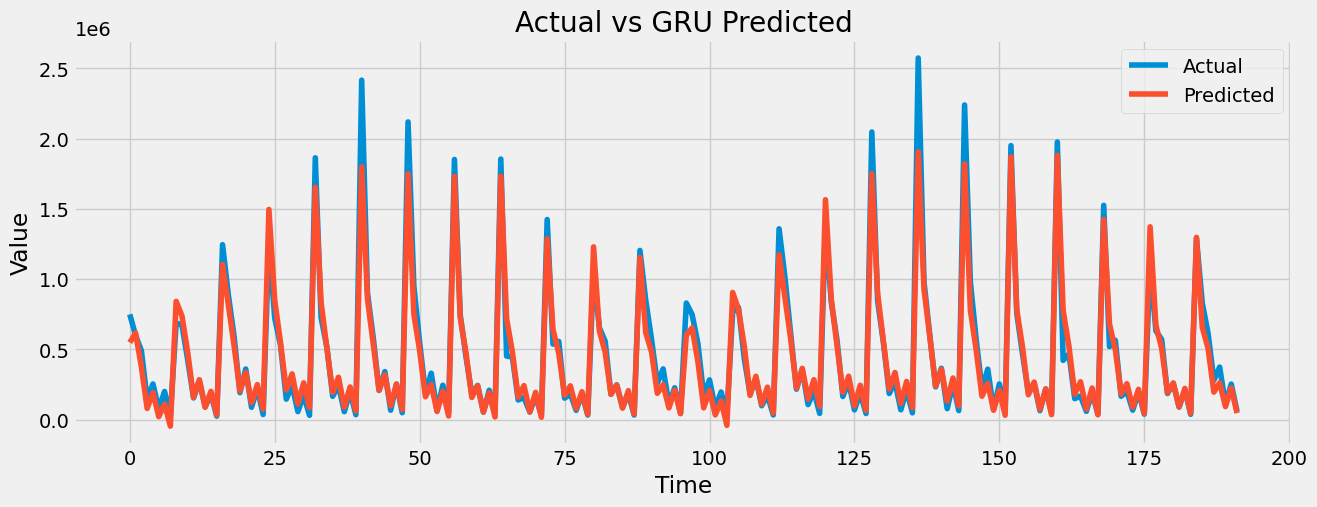

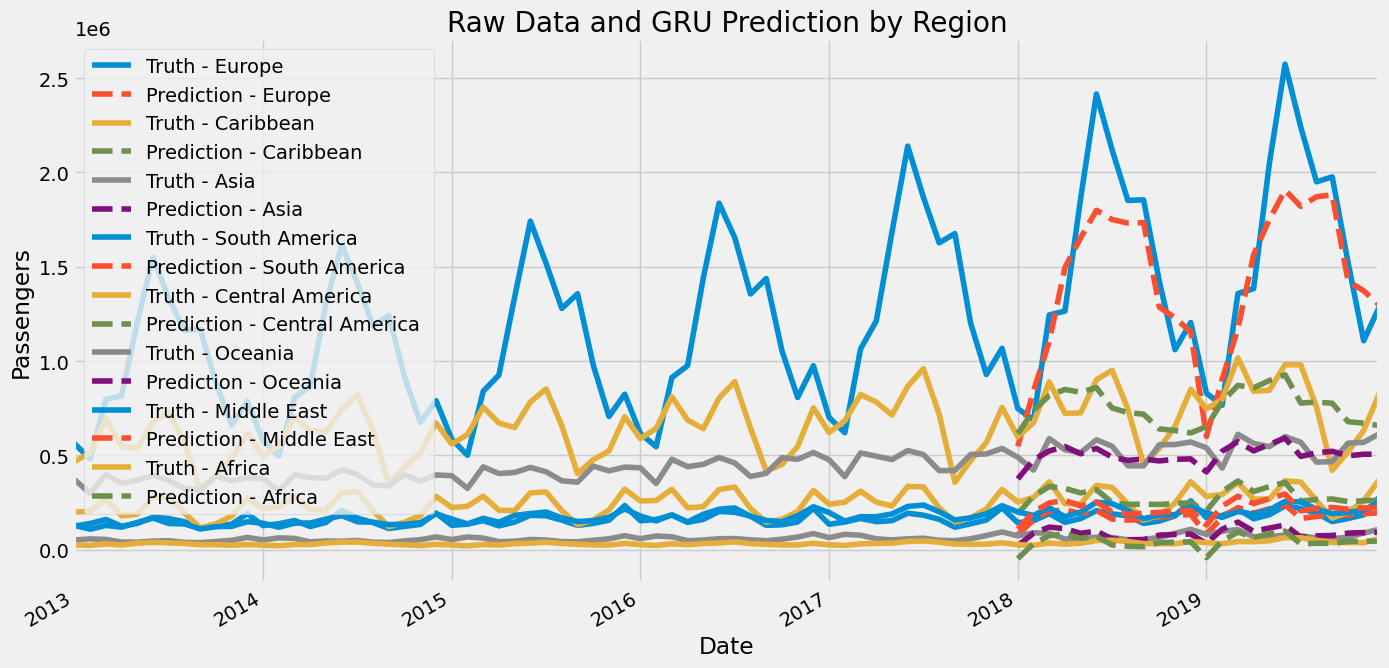

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test


feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

# Reshape input to be 3D [samples, time steps, features] for GRU
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 2. Build GRU Model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(GRU(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

# Make Predictions
y_pred_scaled = model.predict(X_test_reshaped)


y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

# 4. Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Merge predictions with the original data
test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# 5. Visualize the results
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs GRU Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot data and predictions by region
fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend()
ax.set_title('Raw Data and GRU Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()